In [50]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import nlpaug.augmenter.word as naw
import numpy as np
from collections import Counter
from sklearn.utils import shuffle

In [51]:
# read lemmatized docs
df_lemmatized = pd.read_parquet("data/df_lemmatized.parquet")
df_lemmatized.head()

,Ratings,Comment,Review_tokens
0,5,super,"[great, camera, pic, video, battery, life, goo..."
1,5,must buy,"[great, device, let, tell, pro, superb, build,..."
2,5,great product,"[love, older, size, ie, inch, type, definitely..."
3,5,simply awesome,"[se, best, ever, get, beautifully, designed, g..."
4,5,classy product,"[second, ive, long, time, android, user, ill, ..."


In [52]:
df_lemmatized.describe()

,Ratings
count,9713.000000
mean,4.456399
std,1.032911
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [53]:
df_lemmatized["Ratings"].value_counts()

Ratings
5    6788
4    1717
3     535
1     474
2     199
Name: count, dtype: int64

<Axes: >

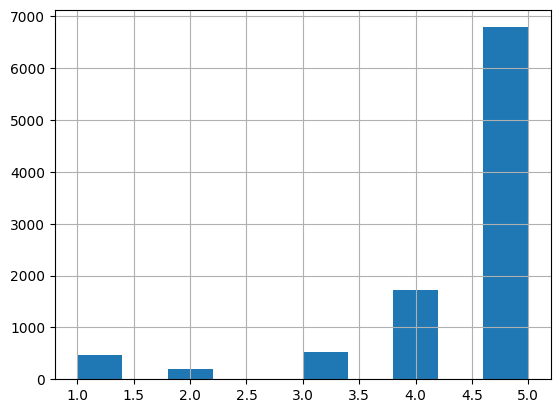

In [54]:
df_lemmatized["Ratings"].hist()

In [55]:
df_lemmatized.dtypes

Ratings           int64
Comment          object
Review_tokens    object
dtype: object

In [56]:
# untokenize
df_lemmatized["Review"] = df_lemmatized["Review_tokens"].apply(lambda x: " ".join(x))
del df_lemmatized["Review_tokens"]
df_lemmatized.head()

,Ratings,Comment,Review
0,5,super,great camera pic video battery life good far s...
1,5,must buy,great device let tell pro superb build quality...
2,5,great product,love older size ie inch type definitely go not...
3,5,simply awesome,se best ever get beautifully designed give cla...
4,5,classy product,second ive long time android user ill tell pro...


In [57]:
features = df_lemmatized[['Review']]
target = df_lemmatized['Ratings']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 7770 samples.
Testing set has 1943 samples.


In [58]:
x_train = [[x] for x in X_train["Review"]]
x_test = [[x] for x in X_test["Review"]]
y_train = [y - 1 for y in y_train]
y_test = [y - 1 for y in y_test]

In [59]:
x_train[-200:-100]

[['awesome super performance nice'],
 ['look good performs good camera soso battery good user always user back oneplus samsung'],
 ['love'],
 ['really liked performance camera got time offer worth buy u get offeri happy battery otherwise complete package'],
 ['io always goodsize perfect thumb reach one handwas using earlier believe transferring data se done minute without connecting wire secure use look elegant classy battery much lasting yes always good'],
 ['many phone performs better price bored bulky phone expect decent handy io best choice love size'],
 ['nice'],
 ['superb battery capacity low'],
 ['yeah good'],
 ['awsm must buy'],
 ['good handy one hand use camera rear good front great performance good fast performing get heated using longer time expected iphones'],
 ['nice charger given'],
 ['great'],
 ['perfect'],
 ['poor battery'],
 ['want go beast gave premium feel hold hand'],
 ['always poor battery energize full body dont battery think taken seriously'],
 ['suprb handset'],

In [60]:
# reduce majority class and augment the rest of the classes with synonyms replacement

# count the number of instances for each class
counter = Counter(y_train)

# find the majority class
majority_class = max(counter, key=counter.get)

# reduce the majority class by X%
undersampling_rate = 0.3
new_x_train = []
new_y_train = []

majority_indices = [i for i, y in enumerate(y_train) if y == majority_class]

# calculate the number of samples to remove
num_remove = int(len(majority_indices) * undersampling_rate)

# randomly select samples to remove
remove_indices = np.random.choice(majority_indices, size=num_remove, replace=False)

new_x_train = [x_train[i] for i in range(len(x_train)) if i not in remove_indices]
new_y_train = [y_train[i] for i in range(len(y_train)) if i not in remove_indices]

# re-count the majority class
counter = Counter(new_y_train)

# perform augmentation on the rest of the classes to balance all the classes
aug = naw.SynonymAug(aug_src='wordnet')

x_train_balanced = []
y_train_balanced = []

for x, y in zip(new_x_train, new_y_train):
    x_train_balanced.append(x)
    y_train_balanced.append(y)
    
    # If this is a minority class, augment it until it's balanced
    while counter[y] < counter[majority_class]:
        augmented_sentence = aug.augment(x[0])
        x_train_balanced.append(augmented_sentence)
        y_train_balanced.append(y)
        counter[y] += 1

# shuffle the data
x_train_balanced, y_train_balanced = shuffle(x_train_balanced, y_train_balanced)

In [61]:
print(str(Counter(y_train_balanced)))

Counter({0: 3802, 3: 3802, 4: 3802, 1: 3802, 2: 3802})


In [62]:
y_train_balanced

[0,
 3,
 0,
 4,
 0,
 4,
 3,
 1,
 2,
 4,
 0,
 3,
 0,
 3,
 2,
 0,
 3,
 3,
 4,
 1,
 1,
 2,
 4,
 4,
 3,
 4,
 3,
 4,
 0,
 3,
 4,
 1,
 3,
 0,
 3,
 0,
 3,
 2,
 3,
 0,
 2,
 3,
 4,
 2,
 3,
 4,
 1,
 0,
 3,
 1,
 3,
 1,
 1,
 2,
 4,
 0,
 2,
 4,
 4,
 0,
 1,
 3,
 1,
 1,
 2,
 3,
 4,
 2,
 2,
 4,
 3,
 0,
 0,
 2,
 4,
 3,
 4,
 1,
 0,
 0,
 0,
 1,
 3,
 4,
 4,
 2,
 0,
 3,
 0,
 1,
 1,
 3,
 2,
 1,
 1,
 2,
 1,
 4,
 0,
 0,
 3,
 3,
 1,
 2,
 4,
 2,
 3,
 0,
 3,
 1,
 4,
 0,
 1,
 4,
 4,
 4,
 1,
 2,
 3,
 2,
 1,
 3,
 1,
 4,
 4,
 4,
 0,
 0,
 2,
 0,
 4,
 4,
 2,
 2,
 3,
 0,
 1,
 4,
 0,
 2,
 0,
 0,
 2,
 4,
 0,
 2,
 0,
 2,
 4,
 3,
 0,
 0,
 4,
 4,
 4,
 4,
 1,
 0,
 1,
 4,
 0,
 2,
 0,
 0,
 4,
 2,
 0,
 4,
 4,
 1,
 0,
 4,
 0,
 3,
 1,
 1,
 0,
 3,
 1,
 2,
 0,
 4,
 0,
 1,
 2,
 0,
 1,
 0,
 2,
 0,
 3,
 0,
 4,
 2,
 0,
 4,
 3,
 2,
 4,
 2,
 0,
 0,
 3,
 3,
 3,
 2,
 4,
 4,
 3,
 1,
 2,
 3,
 1,
 2,
 4,
 3,
 1,
 4,
 3,
 4,
 0,
 1,
 2,
 3,
 3,
 3,
 0,
 2,
 1,
 0,
 4,
 0,
 1,
 3,
 1,
 0,
 3,
 4,
 0,
 2,
 4,
 0,
 3,
 1,
 0,
 2,
 4,
 1,
 3,
 2,


In [63]:
x_train = x_train_balanced.copy()
y_train = y_train_balanced.copy()

In [72]:
print(x_train)

[['fix third political party data cablewhich saw calendar month practically option available returnnever leverage fuddu situation'], ['good average batteryaverage camera average displaybut performance high'], ['disappointed battery say chip reality start using drain fast canspend much thing le battery back worthbrought last week charged full started using video game app running background call made hour battery went downultimately u dont battery back use othe'], ['good'], ['got tertiary party information cablewhich saw month practically option available returnnever purchase fuddu land site'], ['best one'], ['amercement'], ['worst o ever seenk priced android better io worthless'], ['courser n ear missing'], ['loved'], ['got 3rd party data cablewhich examine calendar month practically option uncommitted returnnever purchase fuddu site'], ['excellent'], ['got third party data point cablewhich saw month practically pick available returnnever purchase fuddu internet site'], ['mulct'], ['cou

In [65]:
# load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize and pad sequences
def tokenize_and_pad(text, max_len):
    tokenized = tokenizer.encode_plus(
        text, 
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    return tokenized["input_ids"], tokenized["attention_mask"]

max_len = 512

# Tokenize the sequences
train_tokenized = [tokenize_and_pad(text, max_len) for text in x_train]
test_tokenized = [tokenize_and_pad(text, max_len) for text in x_test]


In [66]:
# Convert train_labels to a tensor
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

In [67]:
y_train_tensor

tensor([0, 3, 0,  ..., 4, 1, 4])

In [68]:
# load BERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=5)

# get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# separate input ids and attention masks
train_input_ids, train_attention_masks = zip(*train_tokenized)
test_input_ids, test_attention_masks = zip(*test_tokenized)

# convert lists of tensors into tensors
train_input_ids = torch.stack(train_input_ids).squeeze()
train_attention_masks = torch.stack(train_attention_masks).squeeze()
test_input_ids = torch.stack(test_input_ids).squeeze()
test_attention_masks = torch.stack(test_attention_masks).squeeze()
print(train_input_ids.shape)
print(y_train_tensor.shape)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([19010, 512])
torch.Size([19010])


In [69]:
import torch

# batch size
batch_size = 32 

# create a DataLoader to handle batching
train_data = torch.utils.data.TensorDataset(train_input_ids, train_attention_masks, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# number of training epochs
epochs = 4

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# training loop
for epoch in tqdm(range(epochs), desc="Epoch"):
    model.train()
    total_loss = 0.0
    
    for batch in tqdm(train_loader, desc="Batch"):
        input_ids, attention_mask, labels = batch
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # print the average loss for this epoch
    print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {total_loss / len(train_loader)}")


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:  25%|██▌       | 1/4 [5:08:20<15:25:00, 18500.10s/it]

Epoch 1/4, Average Loss: 1.5613075556875278


Epoch:  25%|██▌       | 1/4 [7:01:19<21:03:57, 25279.31s/it]


KeyboardInterrupt: 

In [ ]:
# save model
torch.save(model.state_dict(), 'data/model_distilbert.pth')

In [70]:
# evaluate model on the test set

model.eval()  # set the model to evaluation mode

test_data = torch.utils.data.TensorDataset(test_input_ids, test_attention_masks, y_test_tensor)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

all_preds = []
all_labels = []

with torch.no_grad():  # no gradients for evaluation
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        
        # get the predicted classes
        _, preds = torch.max(outputs.logits, dim=1)
        
        # move tensors back to CPU and convert to numpy arrays for metric calculation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.22027792074112199
Precision: 0.5619569415809536
Recall: 0.22027792074112199
F1 Score: 0.27016574183059977


c:\Users\leocb\OneDrive\Documentos\Projects\ReviewsAnalysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[   0    0   90    0    5]
 [   0    0   42    0    2]
 [   0    0   92    0   12]
 [   0    0  278    0   65]
 [   0    0 1021    0  336]]


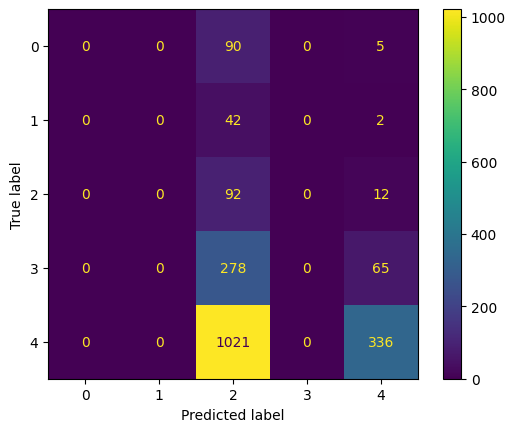

In [71]:
# calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# print the confusion matrix
print("Confusion Matrix:")
print(cm)

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()